# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: Ferrara Luigi
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [1]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torchvision
from torchvision import transforms
import kagglehub
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score
# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/home

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/home

AttributeError: _ARRAY_API not found

Download data with kagglehub

In [2]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [3]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [4]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


<class 'PIL.Image.Image'>


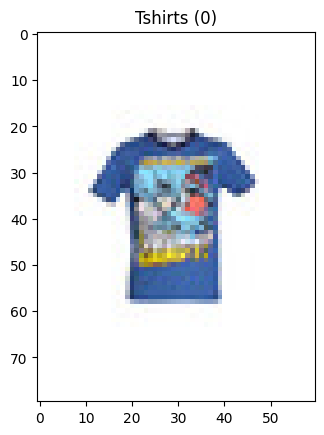

<class 'PIL.Image.Image'>


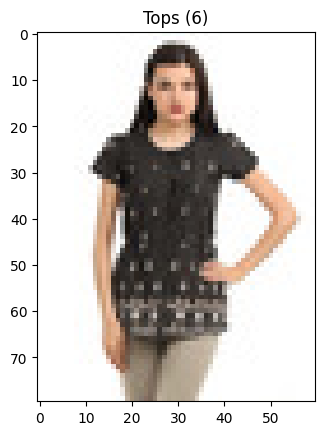

<class 'PIL.Image.Image'>


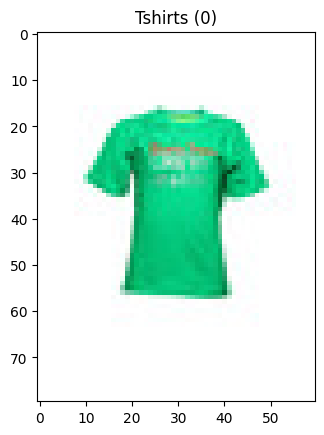

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    print(type(img))
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet
    transforms.ToTensor(),          # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize for RGB images
    # your image transformations 
]) 
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)

label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [ ]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(main_test_dataset, batch_size=64, shuffle=True)

model = torchvision.models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 39)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_dl):.4f}, Accuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}")

In [13]:
# Evaluation phase on test set
model.eval()
test_preds = []
test_labels = []
test_loss = 0.0
with torch.no_grad():  # Disable gradient computation for test set
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
# Calculate test accuracy and balanced accuracy
test_acc = accuracy_score(test_labels, test_preds)
test_bal_acc = balanced_accuracy_score(test_labels, test_preds)
# Print statistics
print(f"Test Loss: {test_loss/len(test_dl):.4f}, Test Accuracy: {test_acc:.4f}, "
      f"Test Balanced Accuracy: {test_bal_acc:.4f}")

Test Loss: 0.4095, Test Accuracy: 0.8773, Test Balanced Accuracy: 0.8266


### Try a new data loader


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # Normalize
])
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)

label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

In [23]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(main_test_dataset, batch_size=64, shuffle=True)

model = torchvision.models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 39)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss/len(train_dl):.4f}, Accuracy: {acc:.4f}, Balanced Accuracy: {bal_acc:.4f}")

Epoch [1/10], Loss: 0.9605, Accuracy: 0.6993, Balanced Accuracy: 0.5708
Epoch [2/10], Loss: 0.5305, Accuracy: 0.8208, Balanced Accuracy: 0.7394
Epoch [3/10], Loss: 0.4286, Accuracy: 0.8521, Balanced Accuracy: 0.7870
Epoch [4/10], Loss: 0.3611, Accuracy: 0.8724, Balanced Accuracy: 0.8186
Epoch [5/10], Loss: 0.3121, Accuracy: 0.8904, Balanced Accuracy: 0.8451
Epoch [6/10], Loss: 0.2745, Accuracy: 0.9018, Balanced Accuracy: 0.8628
Epoch [7/10], Loss: 0.2292, Accuracy: 0.9161, Balanced Accuracy: 0.8838
Epoch [8/10], Loss: 0.1930, Accuracy: 0.9294, Balanced Accuracy: 0.9041
Epoch [9/10], Loss: 0.1509, Accuracy: 0.9458, Balanced Accuracy: 0.9270
Epoch [10/10], Loss: 0.1267, Accuracy: 0.9534, Balanced Accuracy: 0.9360


In [24]:
# Evaluation phase on test set
model.eval()
test_preds = []
test_labels = []
test_loss = 0.0
with torch.no_grad():  # Disable gradient computation for test set
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
# Calculate test accuracy and balanced accuracy
test_acc = accuracy_score(test_labels, test_preds)
test_bal_acc = balanced_accuracy_score(test_labels, test_preds)
# Print statistics
print(f"Test Loss: {test_loss/len(test_dl):.4f}, Test Accuracy: {test_acc:.4f}, "
      f"Test Balanced Accuracy: {test_bal_acc:.4f}")

Test Loss: 0.4039, Test Accuracy: 0.8768, Test Balanced Accuracy: 0.8291


## Task 2

In [8]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from itertools import combinations
import tqdm
from tqdm import tqdm
from torch.utils.data.sampler import BatchSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """
    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [ ]:
train_dataset_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=39, n_samples=3)
main_test_dataset_sampler = BalancedBatchSampler(main_test_dataset.targets, n_classes=39, n_samples=3)
new_test_dataset_sampler = BalancedBatchSampler(new_test_dataset.targets, n_classes=30, n_samples=3)
main_support_dataset_sampler = BalancedBatchSampler(main_support_dataset.targets, n_classes=39, n_samples=3)
new_support_dataset_sampler = BalancedBatchSampler(new_support_dataset.targets, n_classes=30, n_samples=3)
merged_test_dataset_sampler = BalancedBatchSampler(merged_test_dataset.targets, n_classes=69, n_samples=3)
merged_support_dataset_sampler = BalancedBatchSampler(merged_support_dataset.targets, n_classes=69, n_samples=3)

test_cat_dataset_sampler = BalancedBatchSampler(main_test_dataset_cat.targets, n_classes=20, n_samples=3)
support_cat_dataset_sampler = BalancedBatchSampler(main_support_dataset_cat.targets, n_classes=20, n_samples=3)

triplets_train_dataset = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_dataset_sampler)
triplets_main_test_dataset = torch.utils.data.DataLoader(main_test_dataset, batch_sampler=main_test_dataset_sampler)
triplets_new_test_dataset = torch.utils.data.DataLoader(new_test_dataset, batch_sampler=new_test_dataset_sampler)
triplets_main_support_dataset = torch.utils.data.DataLoader(main_support_dataset, batch_sampler=main_support_dataset_sampler)
triplets_new_support_dataset = torch.utils.data.DataLoader(new_support_dataset, batch_sampler=new_support_dataset_sampler)
triplets_merged_test_dataset = torch.utils.data.DataLoader(merged_test_dataset, batch_sampler=merged_test_dataset_sampler)
triplets_merged_support_dataset = torch.utils.data.DataLoader(merged_support_dataset, batch_sampler=merged_support_dataset_sampler)

triplets_test_cat_dataset = torch.utils.data.DataLoader(main_test_dataset_cat, batch_sampler=test_cat_dataset_sampler)
triplets_supp_cat_dataset = torch.utils.data.DataLoader(main_support_dataset_cat, batch_sampler=support_cat_dataset_sampler)

In [11]:
class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """
    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """
    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):
        triplets = self.triplet_selector.get_triplets(embeddings, target)
        if embeddings.is_cuda:
            triplets = triplets.to(embeddings.device)

        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]

        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)
        return losses.mean()

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.DataLoader,
                 validation_DataLoader: torch.utils.data.DataLoader ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):
            self.model.train() 
            train_losses=[]
            for batch in self.training_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                out = self.model(input)
                loss = self.criterion(out, target)

                loss_value = loss.item()
                #print(f"loss: {loss_value:.4f}", end=' ')
                train_losses.append(loss_value)

                loss.backward()
                self.optimizer.step()

            self.model.eval()
            valid_losses = []

            for batch in self.validation_DataLoader:
                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 39)
model.to(device)
triplet_selector = RandomTripletSelector()
criterion = TripletLoss(margin=1.0, triplet_selector=triplet_selector)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_loader = triplets_train_dataset
val_loader   = triplets_main_support_dataset

num_epochs = 30
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_DataLoader=train_loader,
    validation_DataLoader=val_loader,
    epochs=num_epochs
)

'Set True to train the net'
train_flag = False
if train_flag:
    trainer.run_trainer()

    # Save the embedding weights
    os.makedirs("checkpoints", exist_ok=True)
    torch.save(model.state_dict(), "checkpoints/embedding_net.pth")
    print("Training complete. Model saved to checkpoints/embedding_net.pth")

Using device: cpu


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training complete. Model saved to checkpoints/embedding_net.pth


In [ ]:
# Run to load the checkpoints of the net
checkpoint = torch.load('checkpoints/embedding_net.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Testing the model on different scenarios

In [ ]:
def extract_embeddings(model, dataloader):
    """
    Extract embeddings from the model for the given dataloader.
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
    Returns:
        torch.Tensor: Concatenated embeddings from the model.
        torch.Tensor: Corresponding labels for the embeddings.
    """
    device = next(model.parameters()).device  
    embeddings = []
    labels = []
    image_ids = []
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            output = model(x)
            embeddings.append(output.cpu())
            labels.append(y.cpu())
            image_ids.append(dataloader.dataset.df.iloc[i]["imageId"])
    return torch.cat(embeddings), torch.cat(labels), image_ids

In [ ]:
# scenario 1
embeddings1, labels1, img_ids1 = extract_embeddings(model, triplets_main_test_dataset)
embeddings2, labels2, img_ids2= extract_embeddings(model, triplets_train_dataset)

# scenario 2
embeddings3, labels3, img_ids3 = extract_embeddings(model, triplets_main_test_dataset)
embeddings4, labels4, img_ids4 = extract_embeddings(model, triplets_main_support_dataset)

# scenario 3
embeddings5, labels5, img_ids5 = extract_embeddings(model, triplets_new_test_dataset)
embeddings6, labels6, img_ids6 = extract_embeddings(model, triplets_new_support_dataset)

# scenario 4
embeddings7, labels7, img_ids7 = extract_embeddings(model, triplets_merged_test_dataset)
embeddings8, labels8, img_ids8 = extract_embeddings(model, triplets_merged_support_dataset)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_scenario(test_embeddings, test_labels, support_embeddings, support_labels):
    # Fit k-NN on the support set
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(support_embeddings, support_labels)

    # Predict on the test set
    preds = knn.predict(test_embeddings)

    # Compute accuracy
    acc = accuracy_score(test_labels, preds)
    return acc

# Scenario 1: Main test set with main support set
acc1 = evaluate_scenario(embeddings1, labels1, embeddings2, labels2)
print(f"Scenario 1 - Main Test Set with Main Support Set Accuracy: {acc1:.4f}")

# Scenario 2: Main test set with new support set
acc2 = evaluate_scenario(embeddings3, labels3, embeddings4, labels4)
print(f"Scenario 2 - Main Test Set with New Support Set Accuracy: {acc2:.4f}")

# Scenario 3: New test set with new support set
acc3 = evaluate_scenario(embeddings5, labels5, embeddings6, labels6)
print(f"Scenario 3 - New Test Set with New Support Set Accuracy: {acc3:.4f}")

# Scenario 4: Merged test set with merged support set
acc4 = evaluate_scenario(embeddings7, labels7, embeddings8, labels8)
print(f"Scenario 4 - Merged Test Set with Merged Support Set Accuracy: {acc4:.4f}")


Scenario 1 - Main Test Set with Main Support Set Accuracy: 0.4339
Scenario 2 - Main Test Set with New Support Set Accuracy: 0.2594
Scenario 3 - New Test Set with New Support Set Accuracy: 0.3185
Scenario 4 - Merged Test Set with Merged Support Set Accuracy: 0.2060


## Task 3

In [ ]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

In [41]:
from scipy.spatial.distance import cdist

def average_precision(sorted_class_vals, true_class):
    ind = sorted_class_vals == true_class
    num_positive = ind.sum()
    cum_ind = np.cumsum(ind).astype(np.float32)
    enum = np.array(range(1, len(ind)+1)).astype(np.float32)
    return np.sum(cum_ind * ind / enum) / num_positive

# CHECK BETTER THIS PART
'lets say we use main classes support as a support dataset'
support_loader = triplets_main_support_dataset
test_loader = triplets_merged_test_dataset
support_dataset = main_support_dataset
test_dataset = merged_test_dataset
support_embeddings, support_labels, _ = extract_embeddings(model, support_loader)
test_embeddings, test_labels, _ = extract_embeddings(model, test_loader)

distances=cdist(support_embeddings, support_embeddings)
test_labels=np.array(test_dataset.targets)


tensor([ 3,  3,  3, 16, 16, 16, 19, 19, 19, 10, 10, 10,  8,  8,  8,  0,  0,  0,
        34, 34, 34,  5,  5,  5, 33, 33, 33,  1,  1,  1,  9,  9,  9, 31, 31, 31,
         6,  6,  6, 26, 26, 26, 24, 24, 24, 20, 20, 20, 38, 38, 38, 32, 32, 32,
        15, 15, 15, 28, 28, 28,  4,  4,  4, 14, 14, 14,  7,  7,  7, 18, 18, 18,
        37, 37, 37, 22, 22, 22, 29, 29, 29, 11, 11, 11, 17, 17, 17, 12, 12, 12,
        13, 13, 13, 36, 36, 36, 23, 23, 23, 21, 21, 21, 35, 35, 35, 27, 27, 27,
         2,  2,  2, 30, 30, 30, 25, 25, 25])
117
tensor([18, 18, 18, 26, 26, 26, 32, 32, 32, 38, 38, 38, 14, 14, 14, 10, 10, 10,
        35, 35, 35,  6,  6,  6, 30, 30, 30, 21, 21, 21,  3,  3,  3, 36, 36, 36,
        19, 19, 19, 27, 27, 27, 12, 12, 12, 33, 33, 33, 13, 13, 13, 24, 24, 24,
        15, 15, 15,  7,  7,  7, 20, 20, 20, 34, 34, 34,  1,  1,  1, 11, 11, 11,
        29, 29, 29,  4,  4,  4, 31, 31, 31,  8,  8,  8, 16, 16, 16, 22, 22, 22,
        17, 17, 17,  5,  5,  5,  9,  9,  9, 23, 23, 23, 25, 25, 25,  2,

In [ ]:
# Run only one time; define classes for the next section
id2name = dict(zip(test_dataset.df.articleTypeId, test_dataset.df.articleTypeName))
max_id = max(id2name.keys())
classes = [id2name[i] for i in range(max_id+1)]

In [ ]:
def average_precision(sorted_class_vals, true_class):
    ind = sorted_class_vals == true_class
    num_positive = ind.sum()
    cum_ind = np.cumsum(ind).astype(np.float32)
    enum = np.array(range(1, len(ind)+1)).astype(np.float32)
    return np.sum(cum_ind * ind / enum) / num_positive

printing_stats = False
correct_predictions = 0
N = min(len(support_embeddings), len(test_embeddings))
max = 0 
for k in range(N):
    sorted_idx = list((np.argsort(distances[k,:])))
    sorted_idx = sorted_idx[1:]

    if ((test_labels[k] == test_dataset.targets[sorted_idx[0]]) or
        (test_labels[k] == test_dataset.targets[sorted_idx[1]]) or
        (test_labels[k] == test_dataset.targets[sorted_idx[2]])):
        correct_predictions += 1

    if printing_stats:
        print(correct_predictions)
        print("------------------------")
        print("True class:")
        print(classes[test_labels[k]])
        print("Top 3 predicted:")
        print([classes[test_dataset.targets[i]] for i in sorted_idx[:3]])
        print("Average precision {}".format(average_precision(test_labels[sorted_idx], test_labels[k])))
        print()

    if average_precision(test_labels[sorted_idx], test_labels[k]) > max:
        max = average_precision(test_labels[sorted_idx], test_labels[k])
    
print(max)
print(correct_predictions/N)

0.21628080252611673
0.18250377073906485


Fot the next part, Imma do some assumtion because really I have no idea how to proceed otherwise. Then we will eventually refactor and andjust the code according to the specifics

Error rates: [0.0, 0.072, 0.232, 0.361, 0.413, 0.528, 0.578, 0.626, 0.686, 0.728, 0.739, 0.739, 0.739, 0.739, 0.739, 0.739, 0.749, 0.787, 0.796, 0.82, 0.833, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834]
Coverages: [0.0, 0.005, 0.012, 0.02, 0.032, 0.059, 0.094, 0.132, 0.176, 0.258, 0.355, 0.47, 0.569, 0.687, 0.763, 0.833, 0.878, 0.915, 0.946, 0.965, 0.973, 0.981, 0.991, 0.994, 0.995, 0.995, 0.996, 0.996, 0.996, 0.996, 0.998, 0.998, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0

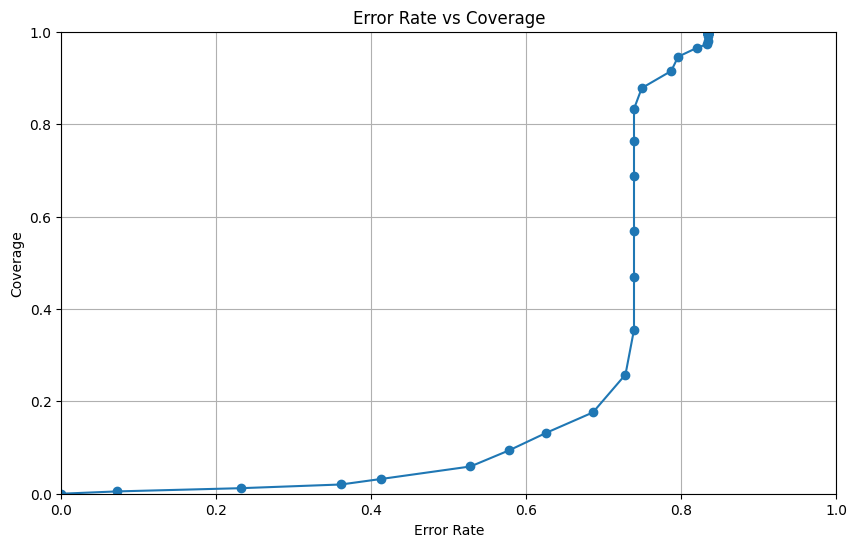

In [ ]:
def compute_error_rate_and_coverage(distances, support_labels, test_labels, threshold):
    error_rate = 0.0
    coverage = 0.0
    N_test = 1000

    for k in range(N_test):
        sorted_idx = list(np.argsort(distances[k, :]))
        sorted_idx = sorted_idx[1:]
        
        if ((test_labels[k] != test_dataset.targets[sorted_idx[0]]) and
        (test_labels[k] != test_dataset.targets[sorted_idx[1]]) and
        (test_labels[k] != test_dataset.targets[sorted_idx[2]]) and
        average_precision(test_labels[sorted_idx], test_labels[k]) < threshold):
            error_rate += 1
        
        '''print(test_labels[k])
        print(test_dataset.targets[sorted_idx[0]])
        print(error_rate)
        print("------------------------")
        print("True class:")
        print(classes[test_labels[k]])
        print("Top 3 predicted:")
        print([classes[test_dataset.targets[i]] for i in sorted_idx[:3]])
        print("Average precision {}".format(average_precision(test_labels[sorted_idx], test_labels[k])))
        print()'''

        if (distances[k, sorted_idx[0]] < threshold or
            distances[k, sorted_idx[1]] < threshold or 
            distances[k, sorted_idx[2]] < threshold):
            coverage += 1

    error_rate /= N_test
    coverage /= N_test
    return error_rate, coverage

# Example usage
thresholds = np.linspace(0, 1, 100)
error_rates = []
coverages = []
for threshold in thresholds:
    error_rate, coverage = compute_error_rate_and_coverage(distances, support_labels, test_labels, threshold)
    error_rates.append(error_rate)
    coverages.append(coverage)

print("Error rates:", error_rates)
print("Coverages:", coverages)

plt.figure(figsize=(10, 6))
plt.plot(error_rates, coverages, marker='o')
plt.title('Error Rate vs Coverage')
plt.xlabel('Error Rate')
plt.ylabel('Coverage')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


## Task 4

## Step 1

In [ ]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset
def extract_embeddings(model, dataloader):
    """
    Extract embeddings from the model for the given dataloader.
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
    Returns:
        torch.Tensor: Concatenated embeddings from the model.
        torch.Tensor: Corresponding labels for the embeddings.
    """
    device = next(model.parameters()).device 
    embeddings = []
    labels = []
    image_ids = []
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            output = model(x)
            embeddings.append(output.cpu())
            labels.append(y.cpu())
            for j in range(len(y)):
                image_ids.append(dataloader.dataset.df.iloc[i * len(y) + j]["imageId"])
    return torch.cat(embeddings), torch.cat(labels), image_ids

embeddings1, labels1, images1 = extract_embeddings(model, triplets_main_test_dataset)
embeddings2, labels2, images2 = extract_embeddings(model, triplets_train_dataset)

def filter_first_n_classes(embeddings, labels, n=10):
    mask = labels < n
    return mask, embeddings[mask], labels[mask]

n_classes_to_plot = 10
train_mask, embeddings_train_10, labels_train_10 = filter_first_n_classes(embeddings2, labels2, n_classes_to_plot)
test_mask, embeddings_test_10, labels_test_10 = filter_first_n_classes(embeddings1, labels1, n_classes_to_plot)

tensor([16, 16, 16, 21, 21, 21, 17, 17, 17,  5,  5,  5, 20, 20, 20,  3,  3,  3,
        15, 15, 15, 29, 29, 29, 19, 19, 19,  7,  7,  7, 18, 18, 18, 34, 34, 34,
        30, 30, 30, 14, 14, 14,  1,  1,  1, 12, 12, 12,  2,  2,  2, 33, 33, 33,
         4,  4,  4, 32, 32, 32, 35, 35, 35, 31, 31, 31,  8,  8,  8,  0,  0,  0,
        23, 23, 23, 28, 28, 28, 10, 10, 10, 11, 11, 11, 38, 38, 38, 36, 36, 36,
        37, 37, 37, 24, 24, 24, 26, 26, 26, 25, 25, 25,  6,  6,  6,  9,  9,  9,
        13, 13, 13, 27, 27, 27, 22, 22, 22])
117
tensor([ 2,  2,  2,  3,  3,  3, 32, 32, 32, 10, 10, 10, 27, 27, 27, 16, 16, 16,
        18, 18, 18, 22, 22, 22, 17, 17, 17, 38, 38, 38, 13, 13, 13, 35, 35, 35,
        36, 36, 36,  5,  5,  5, 12, 12, 12, 34, 34, 34, 23, 23, 23, 29, 29, 29,
        33, 33, 33, 11, 11, 11, 24, 24, 24, 14, 14, 14, 28, 28, 28, 25, 25, 25,
         8,  8,  8, 15, 15, 15,  0,  0,  0,  7,  7,  7, 37, 37, 37, 30, 30, 30,
         9,  9,  9,  6,  6,  6, 21, 21, 21,  1,  1,  1,  4,  4,  4, 20,

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def reduce_dimensions(embeddings, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Unsupported method: choose 'tsne' or 'pca'")
    return reducer.fit_transform(embeddings)

reduced_train_2d = reduce_dimensions(embeddings_train_10.numpy(), method='tsne')
reduced_test_2d = reduce_dimensions(embeddings_test_10.numpy(), method='tsne')

reduced_train_2d_pca = reduce_dimensions(embeddings_train_10.numpy(), method='pca')
reduced_test_2d_pca = reduce_dimensions(embeddings_test_10.numpy(), method='pca')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


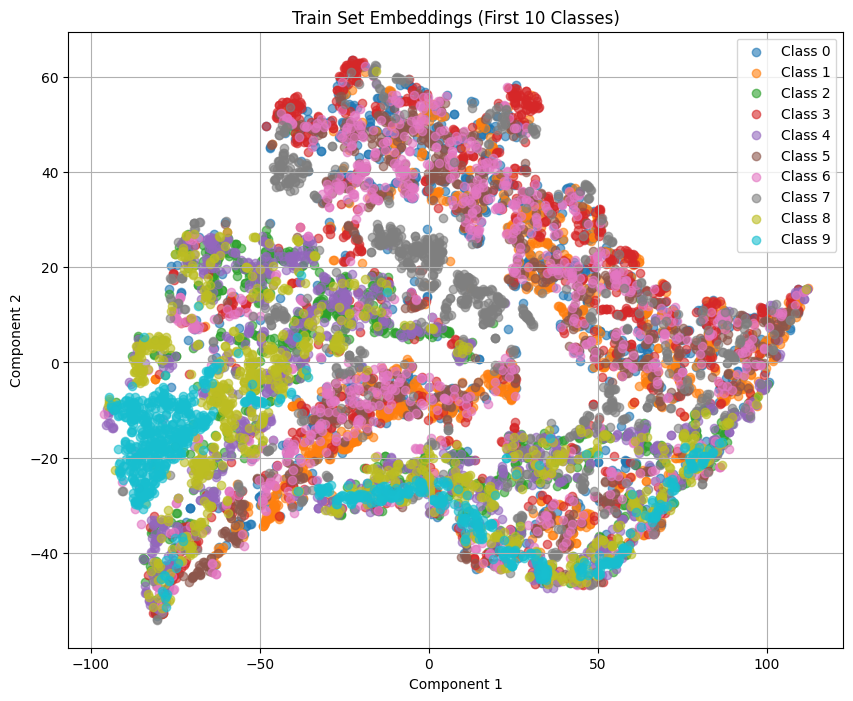

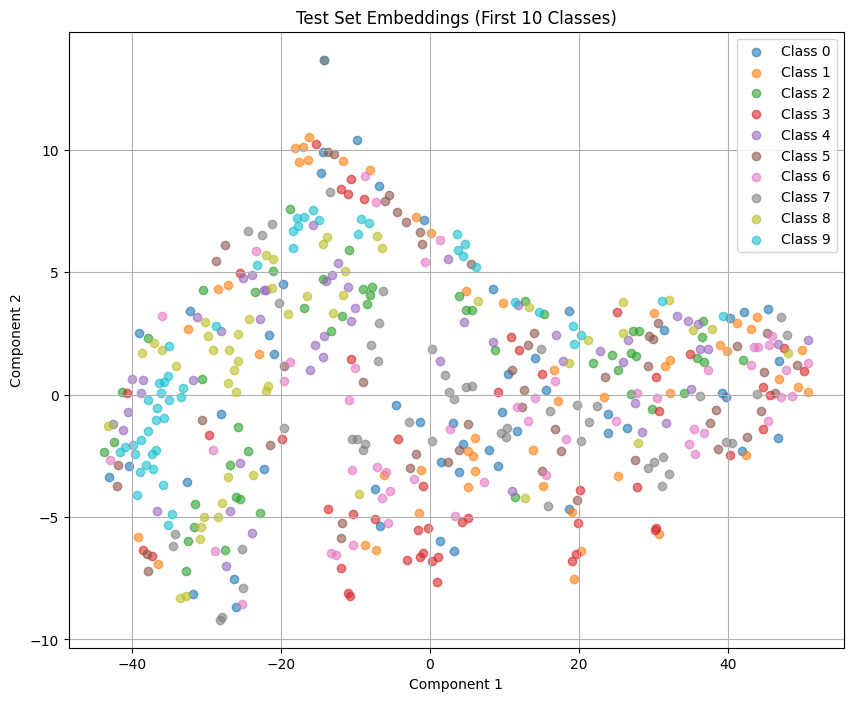

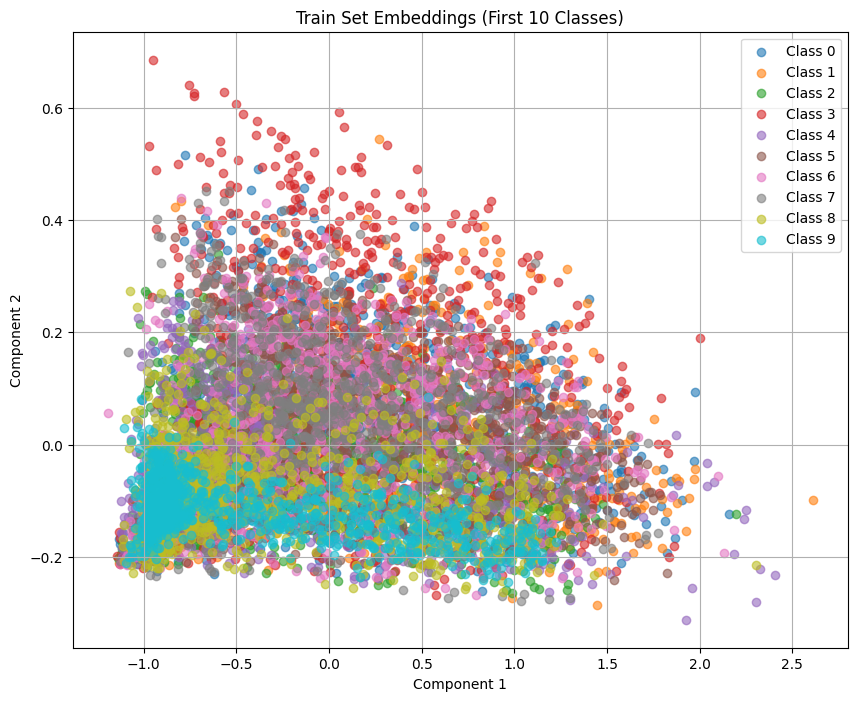

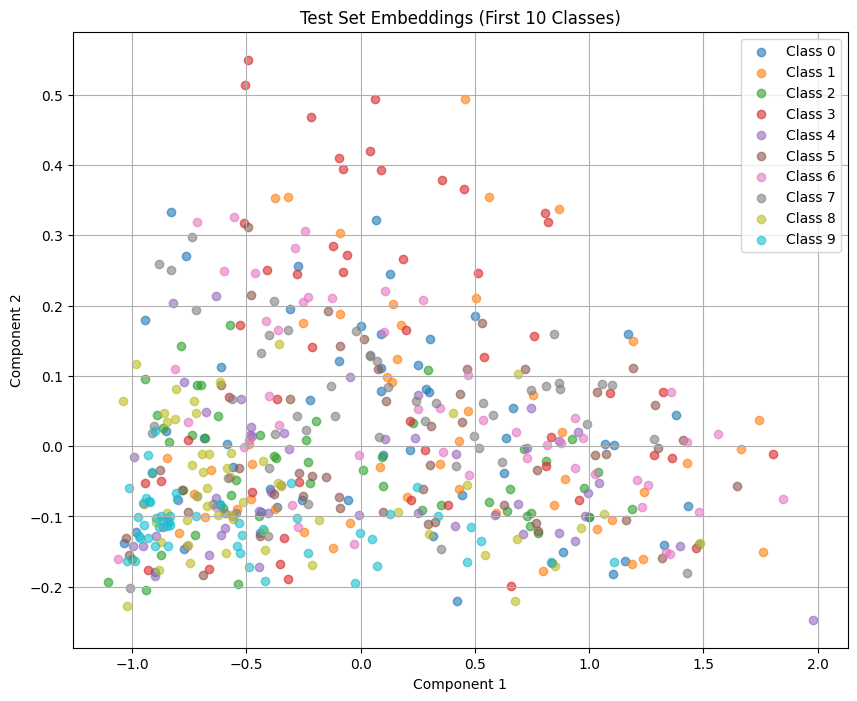

In [24]:
import matplotlib.pyplot as plt

def plot_embeddings(reduced_embeddings, labels, title):
    plt.figure(figsize=(10, 8))
    for label in range(10):
        idx = labels == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f'Class {label}', alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

'----------------------------------TSNE----------------------------------'

plot_embeddings(reduced_train_2d, 
                labels_train_10.numpy(), 
                title='Train Set Embeddings (First 10 Classes)')

plot_embeddings(reduced_test_2d, 
                labels_test_10.numpy(), 
                title='Test Set Embeddings (First 10 Classes)')

'----------------------------------PCA----------------------------------'

plot_embeddings(reduced_train_2d_pca, 
                labels_train_10.numpy(), 
                title='Train Set Embeddings (First 10 Classes)')

plot_embeddings(reduced_test_2d_pca, 
                labels_test_10.numpy(), 
                title='Test Set Embeddings (First 10 Classes)')

## Step 2

In [162]:
'''from sklearn import metrics
import matplotlib.pyplot as plt

# Confusion Matrix for the first 10 classes
n_samples = min(labels_train_10.shape[0], labels_test_10.shape[0])
labels_train_10 = labels_train_10[:n_samples]
labels_test_10 = labels_test_10[:n_samples]

confusion_matrix = metrics.confusion_matrix(labels_train_10, labels_test_10)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()'''

'from sklearn import metrics\nimport matplotlib.pyplot as plt\n\n# Confusion Matrix for the first 10 classes\nn_samples = min(labels_train_10.shape[0], labels_test_10.shape[0])\nlabels_train_10 = labels_train_10[:n_samples]\nlabels_test_10 = labels_test_10[:n_samples]\n\nconfusion_matrix = metrics.confusion_matrix(labels_train_10, labels_test_10)\ncm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])\n\ncm_display.plot()\nplt.show()'

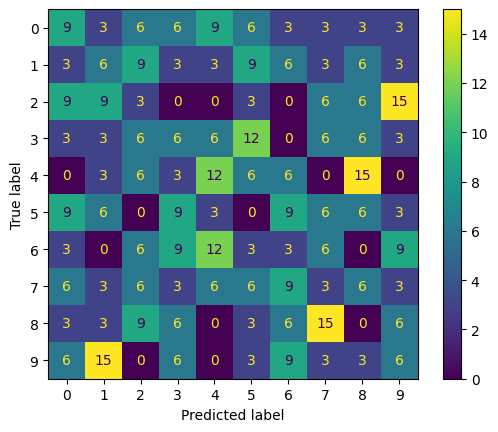

In [25]:
from sklearn import metrics
import matplotlib.pyplot as plt

n_samples = int(np.minimum(labels_train_10.shape[0], labels_test_10.shape[0]))
labels_train_10 = labels_train_10[:n_samples]
labels_test_10 = labels_test_10[:n_samples]

# Get the unique labels from both train and test
unique_labels = np.unique(np.concatenate((labels_train_10, labels_test_10)))

confusion_matrix = metrics.confusion_matrix(labels_train_10, labels_test_10, labels=unique_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = unique_labels)

cm_display.plot()
plt.show()


## Step 3

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


1
[0.10612322 1.8081226 ]
[0.22236195 1.8808756 ]

47
[-8.762455  -6.3717113]
[-8.790393 -6.678556]

572
[-0.8579109  1.454866 ]
[-0.21917064  0.65163565]

335
[-0.4718267  -0.11829894]
[0.66837084 0.18740073]

yessir
yessir


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


yessir
yessir
Sample 70: Shirts (1)


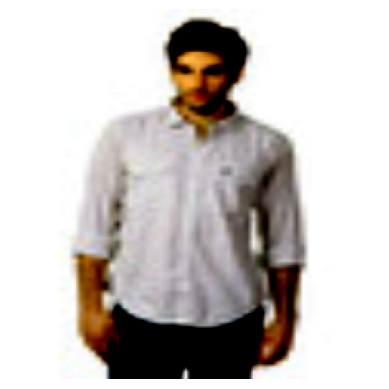

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


Sample 1826: Deodorant (27)


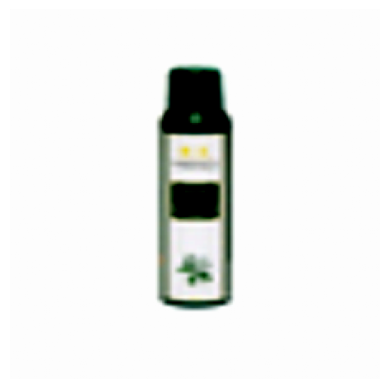

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Sample 22346: Trousers (21)


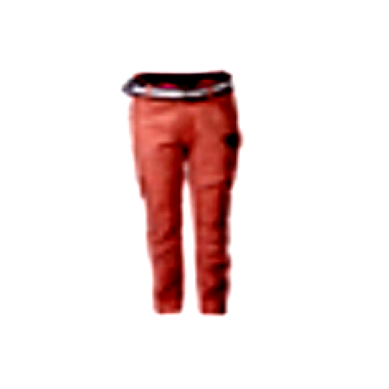

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].


Sample 13052: Handbags (7)


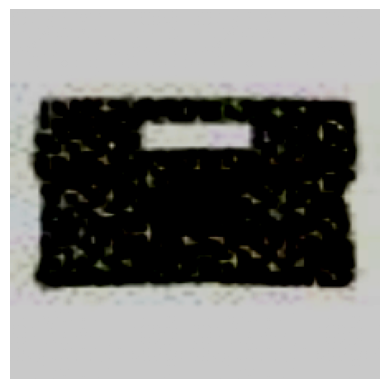

In [ ]:
from torch.utils.data import Subset

def print_sample_info(dataset, index):
    img, label = dataset[index]
    article_type_name = dataset.df.iloc[index]["articleTypeName"]
    print(f"Sample {index}: {article_type_name} ({label.item()})")
    if True:
        plt.imshow(img.permute(1, 2, 0)) 
        plt.axis("off")
        plt.show()

def identify_class(label_id):
    if label_id in label_id_to_label_name:
        return label_id_to_label_name[label_id]
    else:
        return "Unknown Class"

def identify_class_by_name(name):
    for label_id, label_name in label_id_to_label_name.items():
        if label_name == name:
            return label_id
    return -1 

tshirt_class = identify_class_by_name("Tshirts")
shirt_class = identify_class_by_name("Shirts")

test_tshirt_embeddings = embeddings1[labels1 == tshirt_class]
test_shirt_embeddings = embeddings1[labels1 == shirt_class]
train_tshirt_embeddings = embeddings2[labels2 == tshirt_class]
train_shirt_embeddings = embeddings2[labels2 == shirt_class]

'''vector = []
for i in range(len(images1)):
    if labels1[i] == tshirt_class:
        print(labels1[i])
        print(tshirt_class)   
        vector.append(images1[i])'''

test_tshirt_images = [images1[i] for i in range(len(images1)) if labels1[i] == tshirt_class]
test_shirt_images = [images1[i] for i in range(len(images1)) if labels1[i] == shirt_class]
train_tshirt_images = [images2[i] for i in range(len(images2)) if labels2[i] == tshirt_class]
train_shirt_images = [images2[i] for i in range(len(images2)) if labels2[i] == shirt_class]

test_tshirt_embeddings = reduce_dimensions(test_tshirt_embeddings.numpy(), method='tsne')
test_shirt_embeddings = reduce_dimensions(test_shirt_embeddings.numpy(), method='tsne')
train_tshirt_embeddings = reduce_dimensions(train_tshirt_embeddings.numpy(), method='tsne')
train_shirt_embeddings = reduce_dimensions(train_shirt_embeddings.numpy(), method='tsne')

test_centroids = {
    "Tshirts": test_tshirt_embeddings.mean(axis=0),
    "Shirts": test_shirt_embeddings.mean(axis=0)
}

train_centroids = {
    "Tshirts": train_tshirt_embeddings.mean(axis=0),
    "Shirts": train_shirt_embeddings.mean(axis=0)
}

# compute the euclidian distance between the centroids and all the embeddings and check the closest one
def compute_euclidean_distance(centroid, embeddings):
    min = float('inf')
    min_idx = 0
    for idx, embedding in enumerate(embeddings):
        distance = np.linalg.norm(centroid - embedding)
        if distance < min:
            min = distance
            min_idx = idx
    return min, embedding, min_idx

_, _, idx_test_tshirt = compute_euclidean_distance(test_centroids["Tshirts"], test_tshirt_embeddings)
_, _, idx_test_shirt = compute_euclidean_distance(test_centroids["Shirts"], test_shirt_embeddings)
_, _, idx_train_tshirt = compute_euclidean_distance(train_centroids["Tshirts"], train_tshirt_embeddings)
_, _, idx_train_shirt = compute_euclidean_distance(train_centroids["Shirts"], train_shirt_embeddings)

print(idx_test_tshirt)
print(test_tshirt_embeddings[idx_test_tshirt])
print(test_centroids["Tshirts"])
print()
print(idx_test_shirt)
print(test_shirt_embeddings[idx_test_shirt])
print(test_centroids["Shirts"])
print()
print(idx_train_tshirt)
print(train_tshirt_embeddings[idx_train_tshirt])
print(train_centroids["Tshirts"])
print()
print(idx_train_shirt)
print(train_shirt_embeddings[idx_train_shirt])
print(train_centroids["Shirts"])    
print()

# Display the images corresponding to the embeddings
# plot the image in the merge_dataset which have as imageId test_tshirt_images[idx_test_tshirt]


correct_idx1 = 0
for i in range(len(main_test_dataset)):
    if test_tshirt_images[idx_test_tshirt] == main_test_dataset.df.iloc[i]["imageId"]:
        correct_idx1 = i
        break

correct_idx2 = 0
for i in range(len(main_test_dataset)):
    if test_shirt_images[idx_test_shirt] == main_test_dataset.df.iloc[i]["imageId"]:
        correct_idx2 = i
        break

correct_idx3 = 0
for i in range(len(train_dataset)):
    if train_tshirt_images[idx_train_tshirt] == train_dataset.df.iloc[i]["imageId"]:
        correct_idx3 = i
        break

correct_idx4 = 0
for i in range(len(train_dataset)):
    if train_shirt_images[idx_train_shirt] == train_dataset.df.iloc[i]["imageId"]:
        correct_idx4 = i
        break

print_sample_info(main_test_dataset, correct_idx1)
print_sample_info(main_test_dataset, correct_idx2)
print_sample_info(train_dataset, correct_idx3)
print_sample_info(train_dataset, correct_idx4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.62352943].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.6313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to th

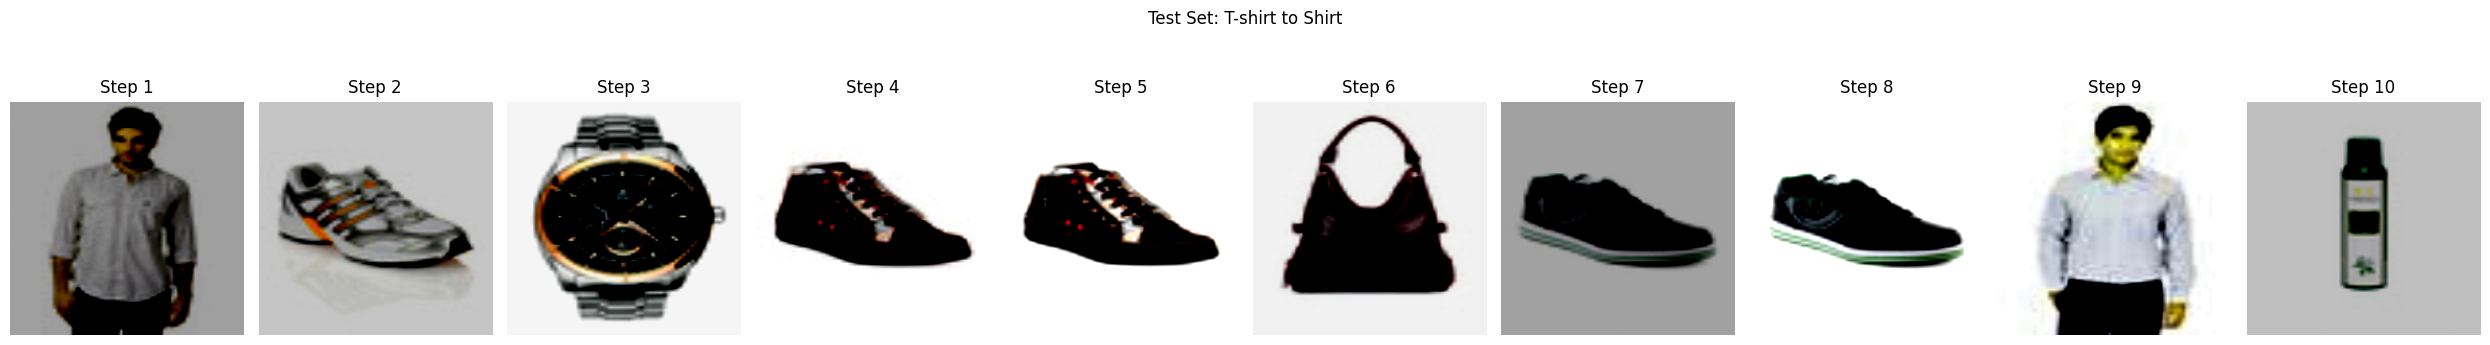

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for 

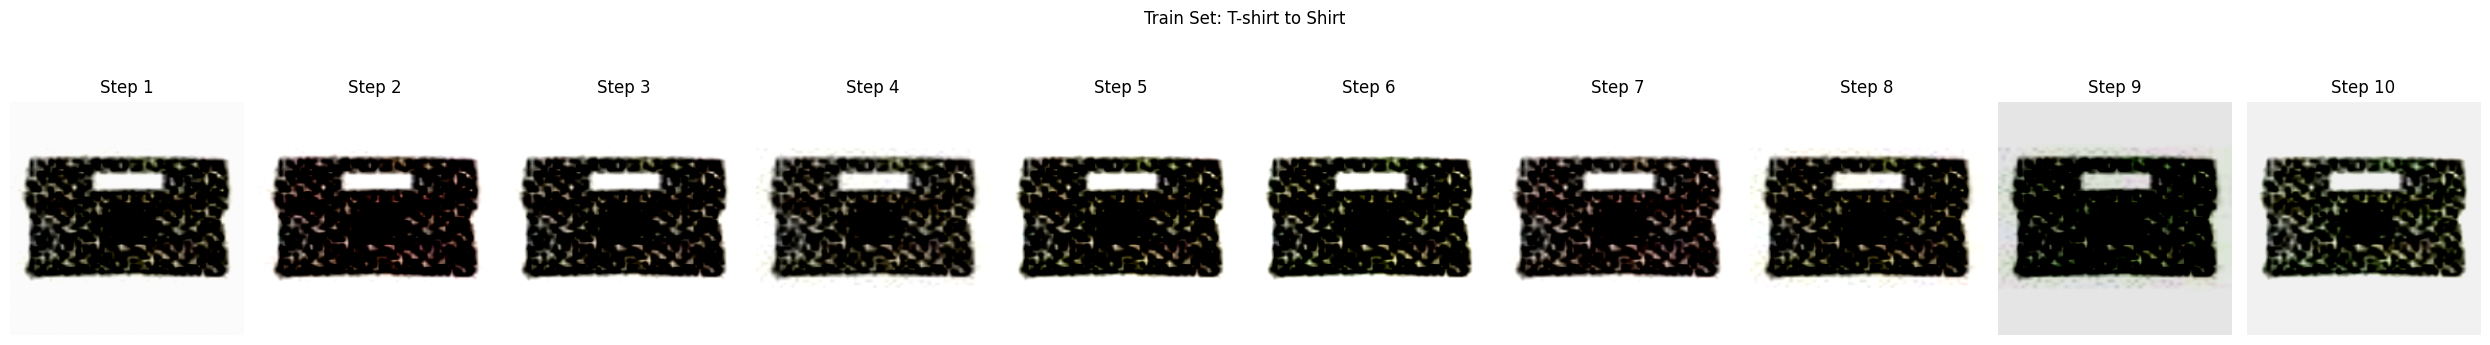

In [ ]:

# compute 10 points between 2 centroids test_centroids["Tshirts"] and test_centroids["Shirts"]
# Generate 10 points between the two test centroids
import matplotlib.pyplot as plt
import numpy as np

def visualize_transition_between_classes(
    centroid_a, 
    centroid_b, 
    embeddings_a, 
    embeddings_b, 
    image_ids_a, 
    image_ids_b, 
    dataset, 
    num_steps=10, 
    title=""
):
    
    # Interpolate points between the centroids
    interpolated_points = [
        centroid_a + (i / (num_steps - 1)) * (centroid_b - centroid_a)
        for i in range(num_steps)
    ]

    # Combine embeddings and image IDs
    all_embeddings = np.concatenate((embeddings_a, embeddings_b), axis=0)
    all_image_ids = image_ids_a + image_ids_b

    # Prepare the figure
    fig, axes = plt.subplots(1, num_steps, figsize=(2.5 * num_steps, 4))

    for i, point in enumerate(interpolated_points):
        # Find the closest embedding
        distances = np.linalg.norm(all_embeddings - point, axis=1)
        closest_idx = np.argmin(distances)
        closest_image_id = all_image_ids[closest_idx]

        # Get index in dataset
        try:
            image_idx = dataset.df.index[dataset.df["imageId"] == closest_image_id][0]
        except IndexError:
            print(f"Image ID {closest_image_id} not found in dataset")
            continue

        img_tensor, _ = dataset[image_idx]
        img_np = img_tensor.permute(1, 2, 0).numpy()

        axes[i].imshow(img_np)
        axes[i].set_title(f"Step {i+1}")
        axes[i].axis("off")

    plt.suptitle(title or "Feature Space Transition")
    plt.tight_layout()
    plt.show()

visualize_transition_between_classes(
    test_centroids["Tshirts"],
    test_centroids["Shirts"],
    test_tshirt_embeddings,
    test_shirt_embeddings,
    test_tshirt_images,
    test_shirt_images,
    main_test_dataset,
    title="Test Set: T-shirt to Shirt"
)

visualize_transition_between_classes(
    train_centroids["Tshirts"],
    train_centroids["Shirts"],
    train_tshirt_embeddings,
    train_shirt_embeddings,
    train_tshirt_images,
    train_shirt_images,
    train_dataset,
    title="Train Set: T-shirt to Shirt"
)


## Step 4

In [36]:
test_embeddings, test_label, test_img_ids = extract_embeddings(model, triplets_test_cat_dataset)
supp_embeddings, supp_labels, supp_img_ids = extract_embeddings(model, triplets_supp_cat_dataset)

accuracy = evaluate_scenario(test_embeddings, test_label, supp_embeddings, supp_labels)
print(f"Scenario 1 - Main Test Set with Main Support Set Accuracy: {accuracy:.4f}")

tensor([ 0,  0,  0,  1,  1,  1, 20, 20, 20,  5,  5,  5, 18, 18, 18, 13, 13, 13,
        10, 10, 10, 16, 16, 16, 11, 11, 11,  8,  8,  8, 19, 19, 19,  7,  7,  7,
         2,  2,  2, 12, 12, 12,  4,  4,  4, 15, 15, 15,  6,  6,  6, 14, 14, 14,
         9,  9,  9,  3,  3,  3])
60
tensor([11, 11, 11, 18, 18, 18,  7,  7,  7,  5,  5,  5,  9,  9,  9,  6,  6,  6,
        12, 12, 12, 16, 16, 16,  0,  0,  0, 14, 14, 14, 19, 19, 19,  1,  1,  1,
         3,  3,  3, 13, 13, 13,  4,  4,  4, 20, 20, 20, 15, 15, 15,  2,  2,  2,
        10, 10, 10,  8,  8,  8])
60
tensor([ 7,  7,  7,  6,  6,  6,  0,  0,  0, 20, 20, 20,  3,  3,  3,  9,  9,  9,
        14, 14, 14, 18, 18, 18, 15, 15, 15, 12, 12, 12,  8,  8,  8, 19, 19, 19,
         4,  4,  4,  5,  5,  5, 16, 16, 16, 10, 10, 10,  1,  1,  1, 11, 11, 11,
         2,  2,  2, 13, 13, 13])
60
tensor([ 5,  5,  5,  3,  3,  3,  1,  1,  1, 16, 16, 16, 14, 14, 14, 13, 13, 13,
         7,  7,  7,  6,  6,  6, 10, 10, 10, 18, 18, 18,  8,  8,  8,  9,  9,  9,
         2, 